In [1]:
import pandas as pd

## data

In [4]:
file_path = 'data\pizza_sales\order_details.csv'
order_details = pd.read_csv(file_path)
order_details.head()

,order_details_id,order_id,pizza_id,quantity
0,1,1,hawaiian_m,1
1,2,2,classic_dlx_m,1
2,3,2,five_cheese_l,1
3,4,2,ital_supr_l,1
4,5,2,mexicana_m,1


In [5]:
file_path = 'data/pizza_sales/orders.csv'
orders = pd.read_csv(file_path)
orders.head()

,order_id,date,time
0,1,2015-01-01,11:38:36
1,2,2015-01-01,11:57:40
2,3,2015-01-01,12:12:28
3,4,2015-01-01,12:16:31
4,5,2015-01-01,12:21:30


In [6]:
file_path = 'data/pizza_sales/pizza_types.csv'
pizza_types = pd.read_csv(file_path, encoding='latin1')
pizza_types.head()

,pizza_type_id,name,category,ingredients
0,bbq_ckn,The Barbecue Chicken Pizza,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,..."
1,cali_ckn,The California Chicken Pizza,Chicken,"Chicken, Artichoke, Spinach, Garlic, Jalapeno ..."
2,ckn_alfredo,The Chicken Alfredo Pizza,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A..."
3,ckn_pesto,The Chicken Pesto Pizza,Chicken,"Chicken, Tomatoes, Red Peppers, Spinach, Garli..."
4,southw_ckn,The Southwest Chicken Pizza,Chicken,"Chicken, Tomatoes, Red Peppers, Red Onions, Ja..."


In [7]:
file_path = 'data/pizza_sales/pizzas.csv'
pizzas = pd.read_csv(file_path)
pizzas.head()

,pizza_id,pizza_type_id,size,price
0,bbq_ckn_s,bbq_ckn,S,12.75
1,bbq_ckn_m,bbq_ckn,M,16.75
2,bbq_ckn_l,bbq_ckn,L,20.75
3,cali_ckn_s,cali_ckn,S,12.75
4,cali_ckn_m,cali_ckn,M,16.75


## load data to db

In [ ]:
%cd data/pizza_sales

In [10]:
import sqlite3
import csv

def create_tables():
  try:
    conn = sqlite3.connect('pizza_sales.db')
    cursor = conn.cursor()

    cursor.execute('''CREATE TABLE IF NOT EXISTS orders (
                    order_id INTEGER PRIMARY KEY,
                    date TEXT,
                    time TEXT
                    )''')

    cursor.execute('''CREATE TABLE IF NOT EXISTS order_details (
                    order_details_id INTEGER PRIMARY KEY,
                    order_id INTEGER,
                    pizza_id TEXT,
                    quantity INTEGER,
                    FOREIGN KEY (order_id) REFERENCES orders(order_id),
                    FOREIGN KEY (pizza_id) REFERENCES pizzas(pizza_id)
                    )''')

    cursor.execute('''CREATE TABLE IF NOT EXISTS pizzas (
                    pizza_id TEXT PRIMARY KEY,
                    pizza_type_id TEXT,
                    size TEXT,
                    price REAL,
                    FOREIGN KEY (pizza_type_id) REFERENCES pizza_types(pizza_type_id)
                    )''')

    cursor.execute('''CREATE TABLE IF NOT EXISTS pizza_types (
                    pizza_type_id TEXT PRIMARY KEY,
                    name TEXT,
                    category TEXT,
                    ingredients TEXT
                    )''')

    conn.commit()
    conn.close()
  except Exception as e:
        print("Error:", e)
  finally:
        conn.close()

def load_data():
    conn = sqlite3.connect('pizza_sales.db')
    cursor = conn.cursor()

    with open('orders.csv', 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            cursor.execute('INSERT INTO orders (order_id, date, time) VALUES (?, ?, ?)', row)

    with open('order_details.csv', 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            cursor.execute('INSERT INTO order_details (order_details_id, order_id, pizza_id, quantity) VALUES (?, ?, ?, ?)', row)

    with open('pizzas.csv', 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            cursor.execute('INSERT INTO pizzas (pizza_id, pizza_type_id, size, price) VALUES (?, ?, ?, ?)', row)

    with open('pizza_types.csv', 'r', encoding='latin1') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            cursor.execute('INSERT INTO pizza_types (pizza_type_id, name, category, ingredients) VALUES (?, ?, ?, ?)', row)

    conn.commit()
    conn.close()

create_tables()
load_data()


## Схема бази даних

Побудуємо схему бази даних за допомогою DbVisualizer. Діаграму можна переглянути в diagram.png


## Чи є у закладу пікові години?

In [11]:
orders['time'] = pd.to_datetime(orders['time'])
hourly_orders = orders.groupby(orders['time'].dt.hour).size()

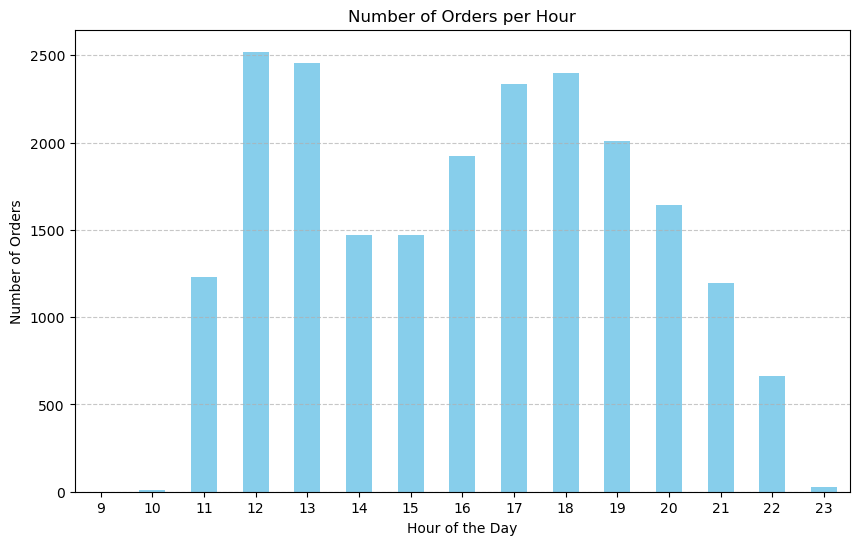

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
hourly_orders.plot(kind='bar', color='skyblue')
plt.title('Number of Orders per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


За графіком вижче можна побачити, що пікові години ближче **о 12 та о 18.** Для детальнішого аналізу переглянемо **дні тижні**:




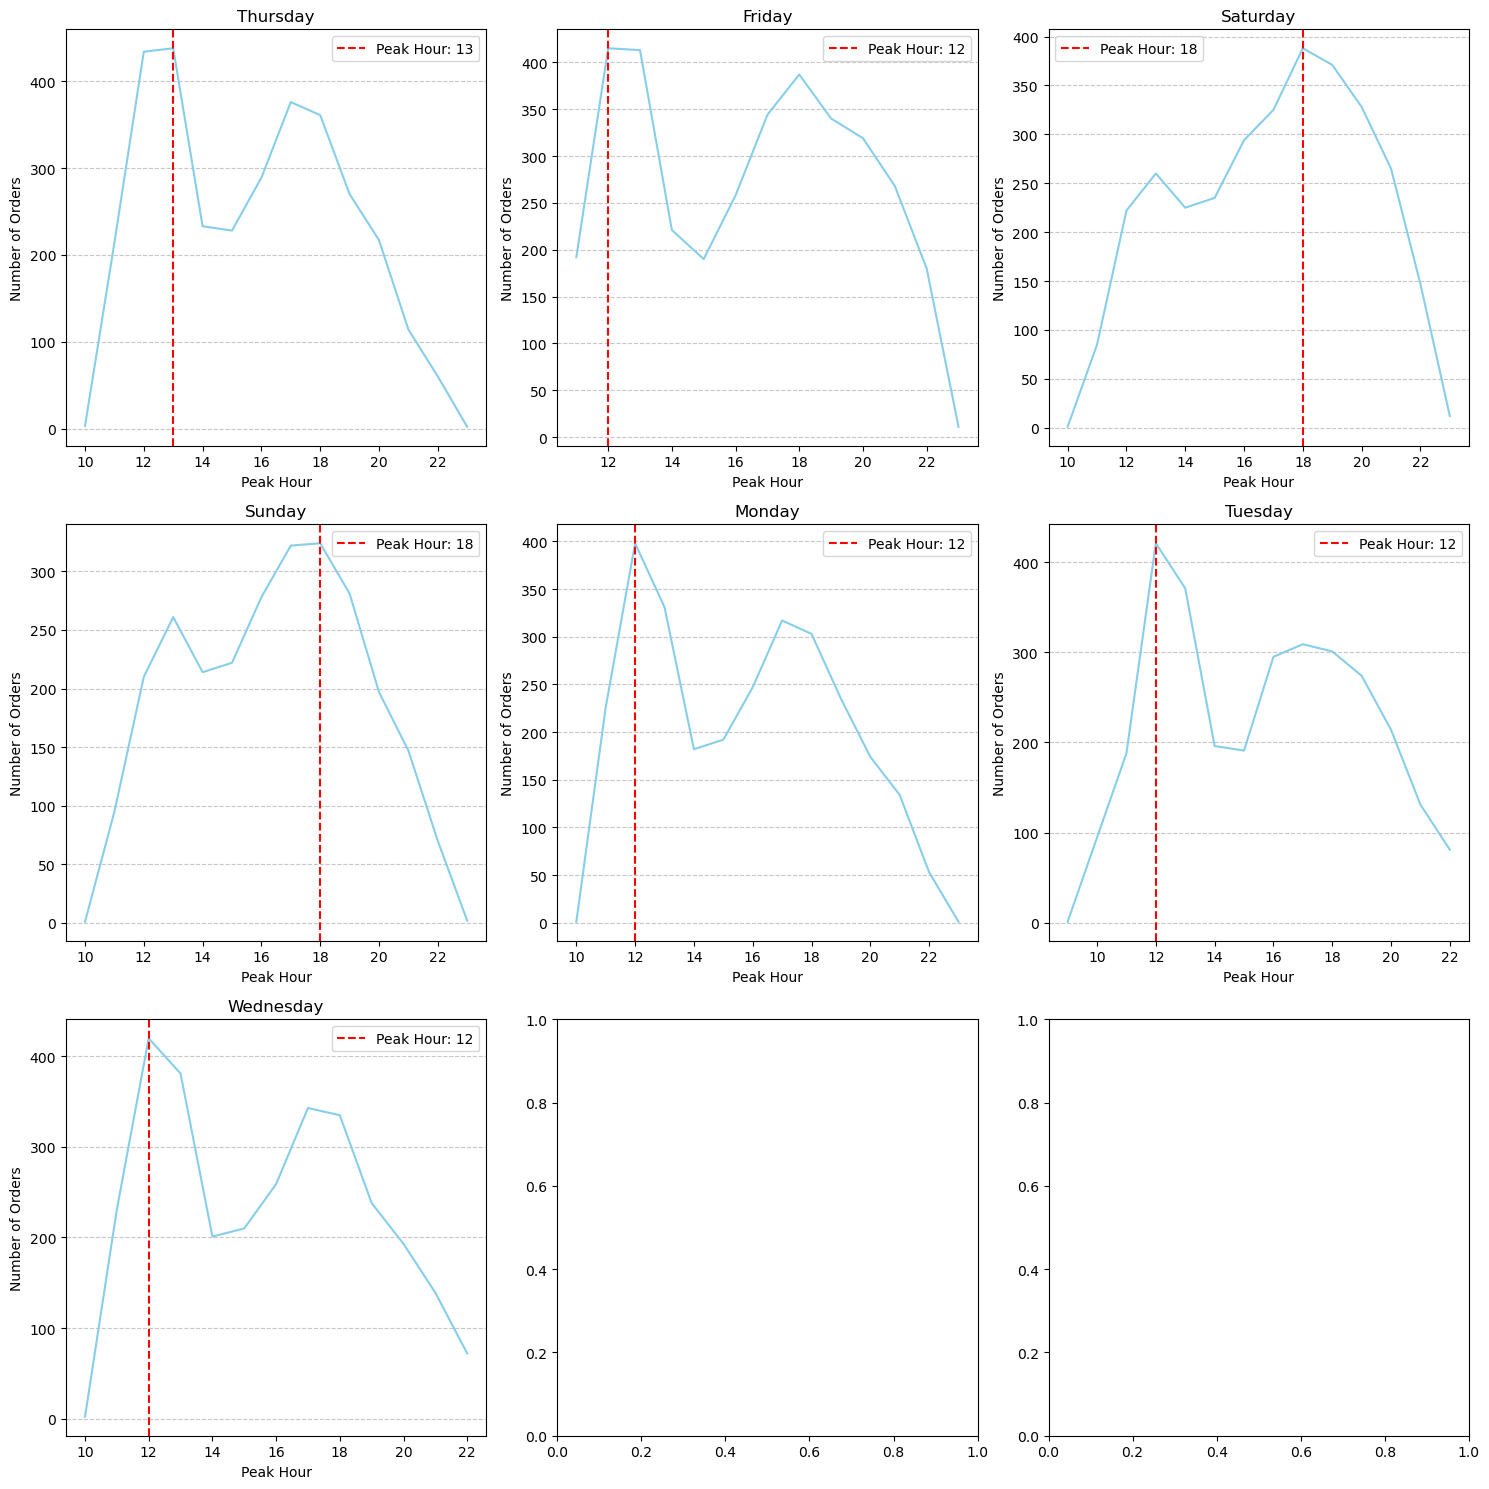

In [13]:
orders['date'] = pd.to_datetime(orders['date'])
orders['weekday'] = orders['date'].dt.day_name()

weekday_peak_hours = {}
for weekday in orders['weekday'].unique():
    weekday_data = orders[orders['weekday'] == weekday]
    peak_hour = weekday_data.groupby(weekday_data['time'].dt.hour).size().idxmax()
    weekday_peak_hours[weekday] = peak_hour

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.ravel()

for i, (weekday, peak_hour) in enumerate(weekday_peak_hours.items()):
    weekday_data = orders[orders['weekday'] == weekday]
    hourly_orders = weekday_data.groupby(weekday_data['time'].dt.hour).size()
    axs[i].plot(hourly_orders.index, hourly_orders.values, color='skyblue')
    axs[i].set_title(weekday)
    axs[i].set_xlabel('Peak Hour')
    axs[i].set_ylabel('Number of Orders')
    axs[i].axvline(x=peak_hour, color='red', linestyle='--', label=f'Peak Hour: {peak_hour}')
    axs[i].legend()
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


У будні дні година пік - **12**, по вихідним - **18**

## Чи існує певна сезонна кореляція продажів?

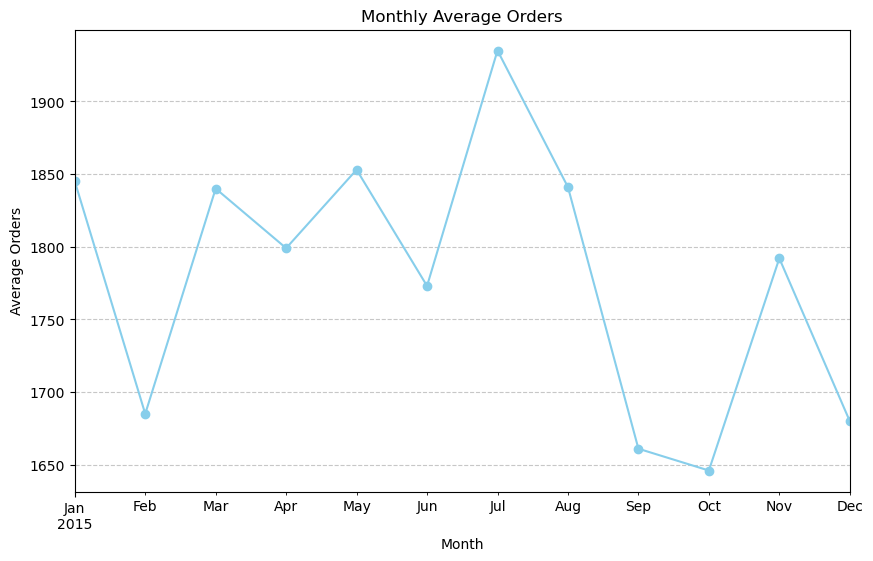

In [14]:
monthly_orders = orders.resample('M', on='date').size()

plt.figure(figsize=(10, 6))
monthly_orders.plot(marker='o', color='skyblue', linestyle='-')
plt.title('Monthly Average Orders')
plt.xlabel('Month')
plt.ylabel('Average Orders')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


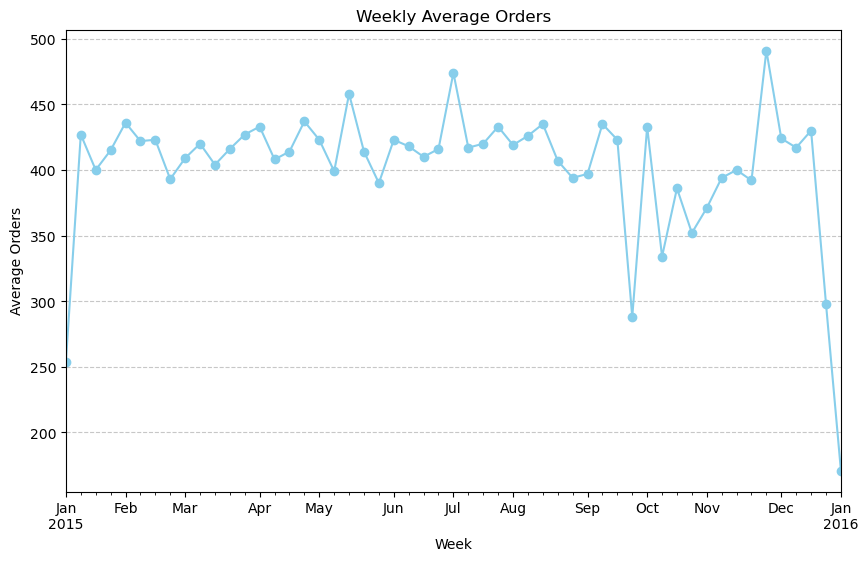

In [15]:
weekly_orders = orders.resample('W', on='date').size()

plt.figure(figsize=(10, 6))
weekly_orders.plot(marker='o', color='skyblue', linestyle='-')
plt.title('Weekly Average Orders')
plt.xlabel('Week')
plt.ylabel('Average Orders')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

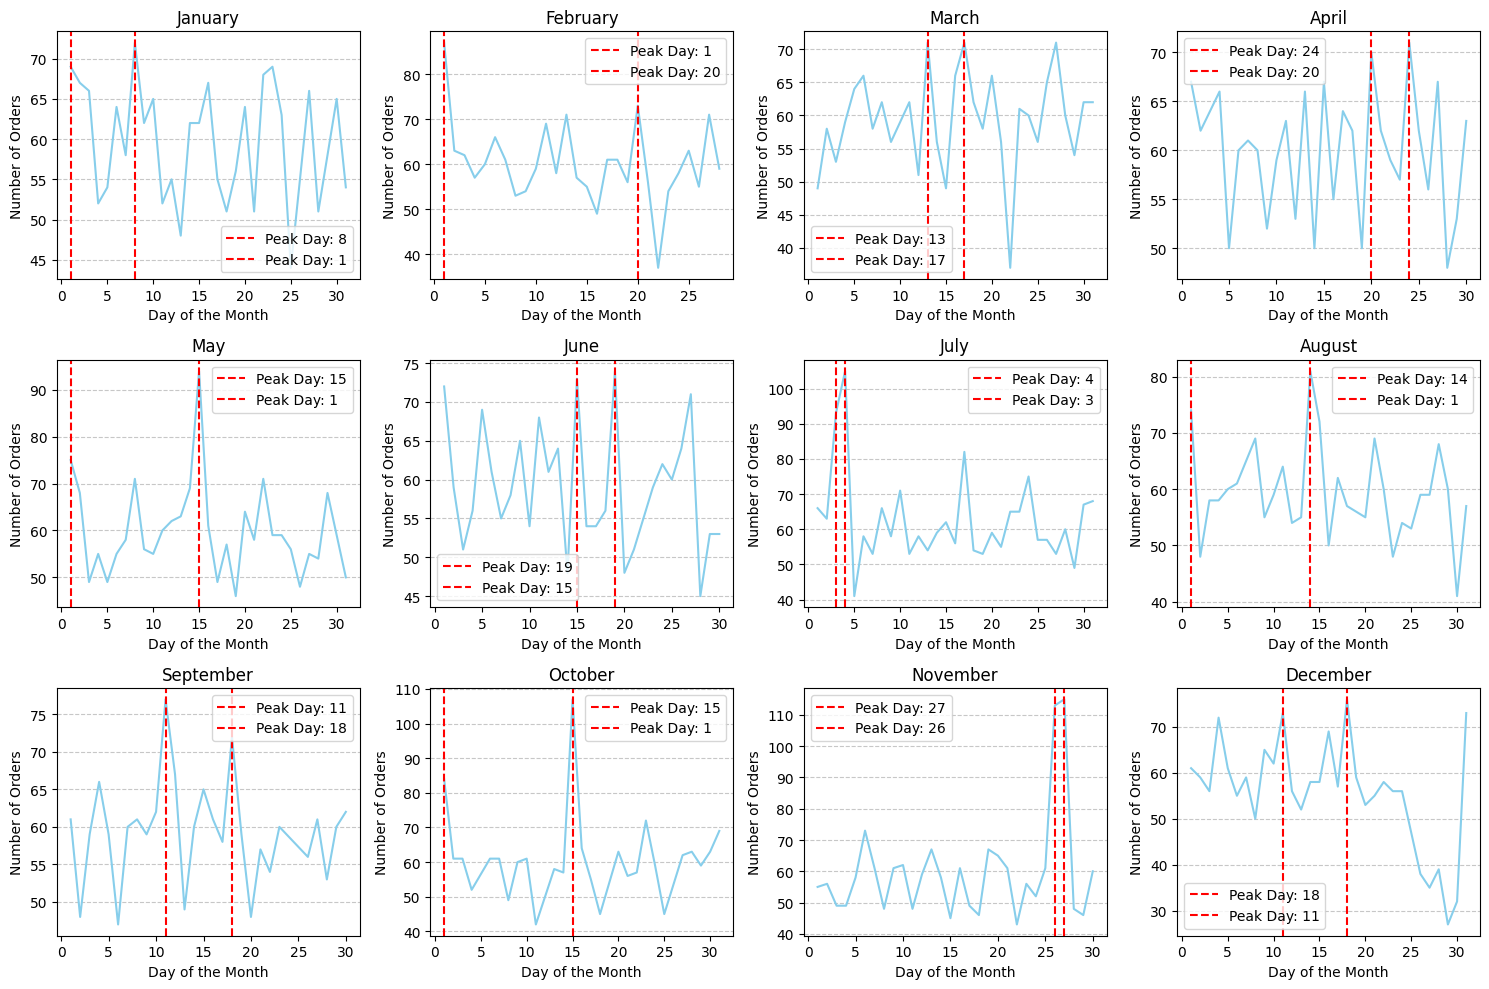

In [15]:
monthly_peak_days = {}
for month, month_data in orders.groupby(orders['date'].dt.to_period('M')):
    peak_days = month_data.groupby(month_data['date'].dt.day).size().nlargest(2).index.tolist()
    monthly_peak_days[month] = peak_days

fig, axs = plt.subplots(3, 4, figsize=(15, 10))
axs = axs.ravel()

for i, (month, peak_days) in enumerate(monthly_peak_days.items()):
    month_data = orders[orders['date'].dt.to_period('M') == month]
    daily_orders = month_data.groupby(month_data['date'].dt.day).size()
    axs[i].plot(daily_orders.index, daily_orders.values, color='skyblue')
    axs[i].set_title(month.strftime('%B'))
    axs[i].set_xlabel('Day of the Month')
    axs[i].set_ylabel('Number of Orders')
    for peak_day in peak_days:
      axs[i].axvline(x=peak_day, color='red', linestyle='--', label=f'Peak Day: {peak_day}')
    axs[i].legend()
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


За потижневим графіком можна сказати, що кількість замовлень майже стабільна до настання осені, але зі скачками в певні тижні. Наприклад найбільше замовлень було в середині літа - Липні, де 3-го та 4-го чисел було приблизно по сотні (залежить від факторів місця положення закладу). Восени було більше випадків кількості замовлень в тиждень менше 50, аніж в інші сезони.

## Чи варто вилучити певні позиції з меню, і якщо так, то які саме?

In [16]:
pizza_types['category'].unique()

array(['Chicken', 'Classic', 'Supreme', 'Veggie'], dtype=object)

Підрахунок кількості замовлень для кожного типу піци

In [17]:
merged_df = pd.merge(pd.merge(pd.merge(orders, order_details, on='order_id'), pizzas, on='pizza_id'), pizza_types, on='pizza_type_id')
orders_per_pizza_type = merged_df.groupby(['category', 'name']).size().reset_index(name='orders').sort_values(by='orders', ascending=False)

Побудуємо графік замовлень кожного типу піци, де колір віповідає за категорію, до якої припадає піцца, а саме: синій - класична, червоний - куряча, зелений - овочева, жовтий - Supreme.

Можна помітити, що категорія не значно впливає на кількість замовлень.

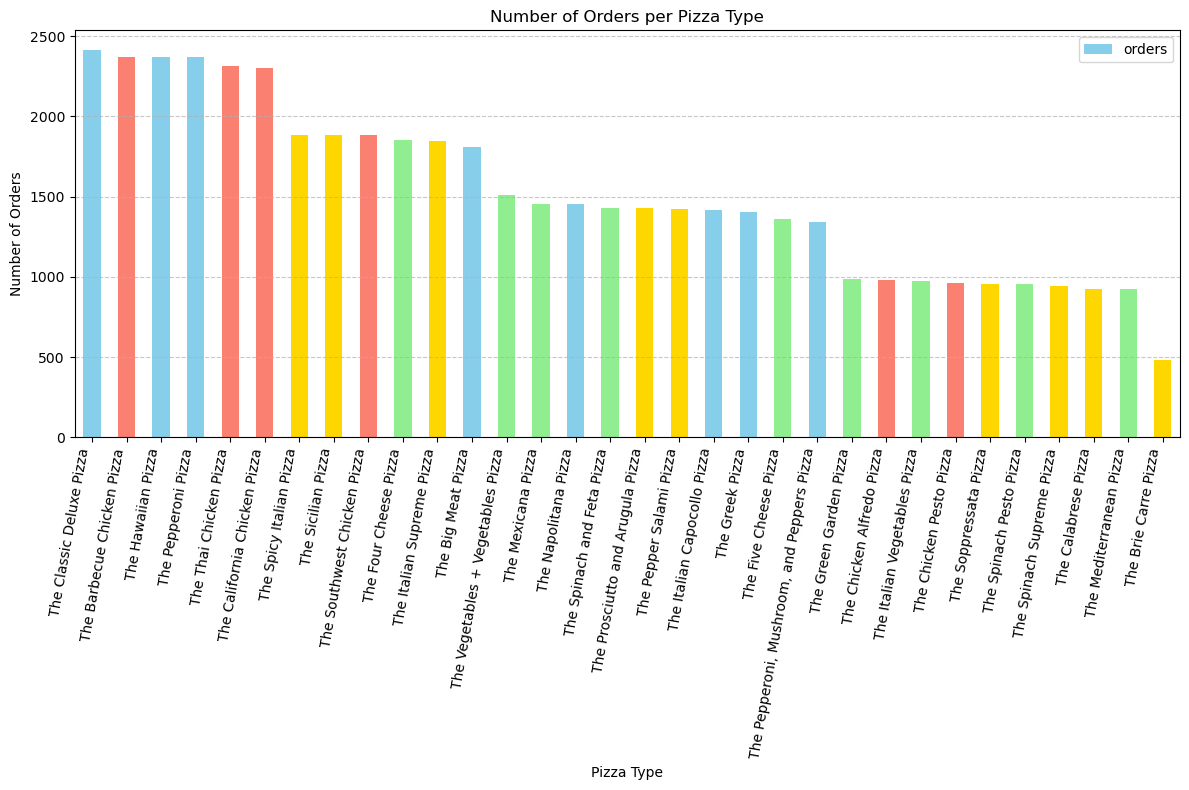

In [18]:
category_colors = {'Classic': 'skyblue', 'Chicken': 'salmon', 'Veggie': 'lightgreen', 'Supreme': 'gold'}

plt.rcParams['figure.figsize'] = [12,8]
orders_per_pizza_type['color'] = orders_per_pizza_type['category'].map(category_colors)
orders_per_pizza_type.plot(kind='bar', x='name', y='orders', color=orders_per_pizza_type['color'])
# plt.bar(x='name', y2, bottom=y, color='b')
plt.title('Number of Orders per Pizza Type')
plt.xlabel('Pizza Type')
plt.ylabel('Number of Orders')
plt.xticks(rotation=80, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

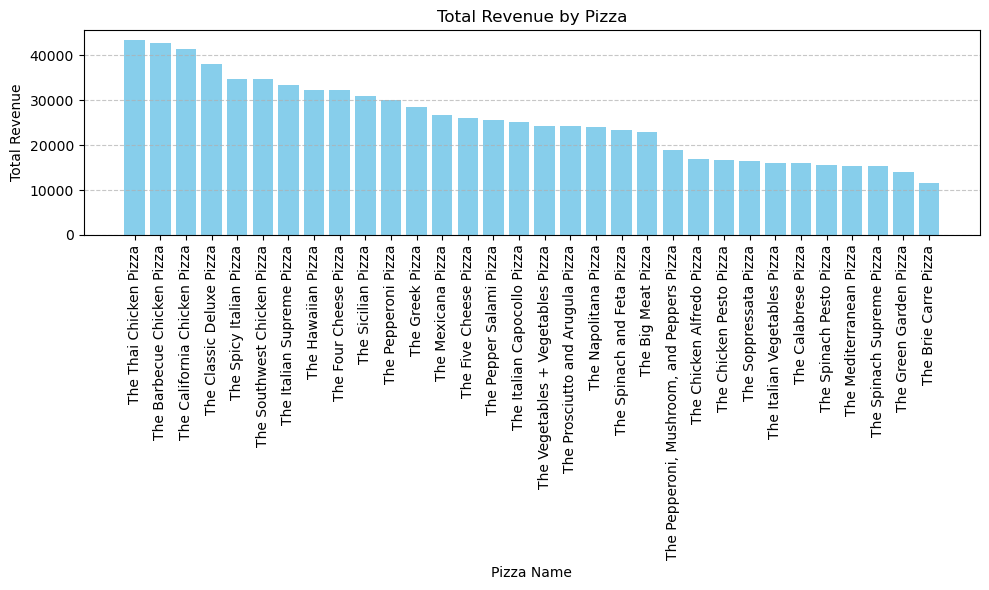

In [19]:
merged_df['total_revenue'] = merged_df['price'] * merged_df['quantity']
pizza_sales = merged_df.groupby('name')['total_revenue'].sum().reset_index()
pizza_sales_sorted = pizza_sales.sort_values(by='total_revenue', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(pizza_sales_sorted['name'], pizza_sales_sorted['total_revenue'], color='skyblue')
plt.xlabel('Pizza Name')
plt.ylabel('Total Revenue')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Total Revenue by Pizza')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

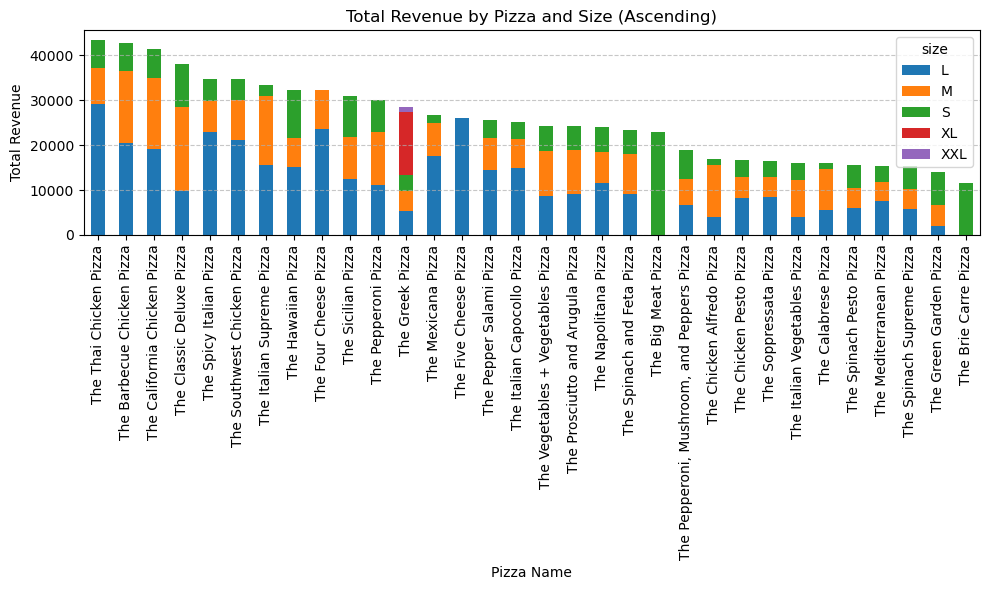

In [20]:
merged_df['total_revenue'] = merged_df['price'] * merged_df['quantity']
pizza_sales = merged_df.groupby(['name', 'size'])['total_revenue'].sum().unstack(fill_value=0)
pizza_sales['total_rev'] = pizza_sales.sum(axis=1)
pizza_sales_sorted = pizza_sales.sort_values(by='total_rev', ascending=False)

pizza_sales_sorted.drop('total_rev', axis=1).plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Pizza Name')
plt.ylabel('Total Revenue')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Total Revenue by Pizza and Size (Ascending)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Менш за все грошей було зароблено на піцці The Brie Carre Pizza. Але, включаючи її единий розмір S, відносно інших того ж розміру вона була одна з найприбутковіших. Найменш прибутковою була єдина піцца розміру ХXL - The Greek Pizza, яку має сенс прибрати (саме цього розміру).

## SQL запити

In [21]:
# Підключення до бази даних
conn = sqlite3.connect('pizza_sales.db')
cursor = conn.cursor()

### Скільки клієнтів в середньому заклад має кожен день?

In [22]:
import sqlite3

# SQL-запит
cursor.execute("""
    SELECT AVG(daily_orders) AS average_orders_per_day
    FROM (
        SELECT date, COUNT(DISTINCT order_id) AS daily_orders
        FROM orders
        GROUP BY date
    )
""")

result = cursor.fetchone()
print("Клієнтів в середньому кожен день:", result[0])

Клієнтів в середньому кожен день: 59.63687150837989


### Яка була середня кількість піц в замовленні восени?

In [23]:
# SQL-запит
cursor.execute("""
    SELECT AVG(pizzas_per_order) AS average_pizzas_per_order
    FROM (
        SELECT order_id, SUM(quantity) AS pizzas_per_order
        FROM order_details
        WHERE order_id IN (
            SELECT order_id
            FROM orders
            WHERE strftime('%m', date) IN ('09', '10', '11')
        )
        GROUP BY order_id
    )
""")

result = cursor.fetchone()
print("Середня кількість піц в замовленні восени:", result[0])



Середня кількість піц в замовленні восени: 2.3610511865071584


### Скільки грошей заклад заробив в червні з трьох найпопулярніших піц?

In [24]:
# SQL-запит
cursor.execute("""
    SELECT SUM(subquery.total_price) AS total_earnings
    FROM (
        SELECT od.pizza_id, SUM(od.quantity) AS total_orders, p.price * SUM(od.quantity) AS total_price
        FROM order_details od
        JOIN pizzas p ON od.pizza_id = p.pizza_id
        WHERE od.order_id IN (
            SELECT order_id
            FROM orders
            WHERE strftime('%m', date) = '06' -- фільтр за місяцем (червень)
        )
        GROUP BY od.pizza_id
        ORDER BY total_orders DESC
        LIMIT 3
    ) AS subquery;
""")

result = cursor.fetchone()
print("Заклад заробив в червні з трьох найпопулярніших піц:", result[0])


Заклад заробив в червні з трьох найпопулярніших піц: 6410.5


### Порахуйте кількість замовлених піц кожного розміру для кожної категорії піц.


In [25]:
# SQL-запит
cursor.execute("""
    SELECT category, size, SUM(quantity) AS total_ordered
    FROM order_details
    JOIN pizzas ON order_details.pizza_id = pizzas.pizza_id
    JOIN pizza_types ON pizzas.pizza_type_id = pizza_types.pizza_type_id
    GROUP BY category, size;
""")

results = cursor.fetchall()
for row in results:
    print(row)

('Chicken', 'L', 4932)
('Chicken', 'M', 3894)
('Chicken', 'S', 2224)
('Classic', 'L', 4057)
('Classic', 'M', 4112)
('Classic', 'S', 6139)
('Classic', 'XL', 552)
('Classic', 'XXL', 28)
('Supreme', 'L', 4564)
('Supreme', 'M', 4046)
('Supreme', 'S', 3377)
('Veggie', 'L', 5403)
('Veggie', 'M', 3583)
('Veggie', 'S', 2663)


In [26]:
# Закриття з'єднання з базою даних
conn.close()